<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.


## Подготовка

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
STATE = 12345

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')

In [ ]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
  df = pd.read_csv(pth1, engine='python', index_col="Unnamed: 0")
elif os.path.exists(pth2):
  df = pd.read_csv(pth2, engine='python', index_col="Unnamed: 0")
else:
  print('Something is wrong')

In [ ]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


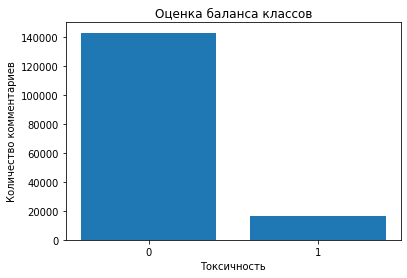

In [ ]:
plt.bar(x=['0', '1'], height=list(df['toxic'].value_counts()))
plt.ylabel('Количество комментариев')
plt.xlabel('Токсичность')
plt.title('Оценка баланса классов');

In [ ]:
df[df['toxic']==0]['toxic'].count() / df[df['toxic']==1]['toxic'].count()

8.841344371679229

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
tokenizer = RegexpTokenizer(r"\w+")

In [ ]:
tqdm.pandas()

df['words'] = df['text'].progress_apply(lambda x:
               [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokenizer.tokenize(x.lower())])

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
df.head()

,text,toxic,words
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, make, under, my..."
1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, match, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, try, to, edit, w..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestion,..."
4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, be, my, hero, any, chance, you, rem..."


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
max(df['words'].apply(lambda x: len(x)))

1403

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
features = df['words'].apply(lambda line: ' '.join(line))

In [ ]:
features

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159446    and for the second time of ask when your view ...
159447    you should be ashamed of yourself that be a ho...
159448    spitzer umm there no actual article for prosti...
159449    and it look like it be actually you who put on...
159450    and i really don t think you understand i come...
Name: words, Length: 159292, dtype: object

In [ ]:
target = df['toxic']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=STATE)

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=STATE)

In [ ]:
features_train.shape, features_valid.shape, features_test.shape

((127433,), (15929,), (15930,))

In [ ]:
vectorizer_tf = TfidfVectorizer(stop_words=stop_words, max_features=50000)
tf_features_train = vectorizer_tf.fit_transform(features_train)
tf_features_valid = vectorizer_tf.transform(features_valid)
tf_features_test = vectorizer_tf.transform(features_test)

In [ ]:
tf_features_train.shape

(127433, 50000)

In [ ]:
tf_features_test.shape, tf_features_valid.shape

((15930, 50000), (15929, 50000))

## Обучение

In [ ]:
%%time

model_LR = LogisticRegression(max_iter=300, class_weight='balanced', solver="saga", n_jobs=-1, random_state=STATE)
model_LR.fit(tf_features_train, target_train)
f1_score(target_valid, model_LR.predict(tf_features_valid))

CPU times: user 13.5 s, sys: 31.5 ms, total: 13.5 s
Wall time: 13.5 s


0.7423719819580791

In [ ]:
%%time

model_cat = CatBoostClassifier(class_weights={0: 1.0, 1: 8.84}, verbose=False, random_state=STATE)
model_cat.fit(tf_features_train, target_train)
f1_score(target_valid, model_cat.predict(tf_features_valid))

CPU times: user 31min 3s, sys: 7.37 s, total: 31min 10s
Wall time: 31min 13s


0.7592954990215264

In [ ]:
%%time

model_RF = RandomForestClassifier(n_estimators=150, class_weight='balanced', n_jobs=-1, random_state=STATE)
model_RF.fit(tf_features_train, target_train)
f1_score(target_valid, model_RF.predict(tf_features_valid))

CPU times: user 10min 44s, sys: 829 ms, total: 10min 45s
Wall time: 10min 45s


0.6506024096385542

Модели обучены, и проверены на валидационной выборке. Из всех моделей единственной удовлетворяющей требования заказчика, является CatBoosting. Не обходимо её окончательно проверить на тестовой выборке.

In [ ]:
f1_score(target_test, model_cat.predict(tf_features_test))

0.7578651685393258

По итогам проверки получаем модель, которую можем рекомендовать заказчику.

## Выводы

При выполнении запроса интернет-магазина «Викишоп» были обработаны текстовые комментарии пользователей. Текст был токенизирован и лематризирован. Результат был отфильтрован на наличие стоп слов и векторизован с помощью *tf-idf*. Был обнаружен дисбаланс классов и предложены модели модели логистической регресии, случайного леса и градиентного бустинга, учитывающие наличие дисбаланса. По результатам проверок на обучающей выборке, были предложены все три модели, так как метрика *f1* была выше 0.82, что является достаточным условием. Далее модели проверены на валидационной выборке и выбрана лучшая модель. После  осуществления проверки была выбрана модель градиентного бустинга и проведена окончательная оценка на тестовой выборке. Метрика  *f1* равна 0,757 что устраивает требования заказчика. Модель рекомендована к использованию.

## Чек-лист проверки

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны